In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
batch_size = 128
validation_data_size = 0.2
#transformers
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    #https://github.com/kuangliu/pytorch-cifar/issues/19
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#Load Data
train_data = datasets.CIFAR10('data',train=True,transform=transform,download=True)
test_data = datasets.CIFAR10('data',train=False,transform=transform,download=True)

#Divide train data to train , validation data
train_data_size = len(train_data)
indices = list(range(train_data_size))
np.random.shuffle(indices)
split_index = int(np.floor(validation_data_size*train_data_size))
train_indices, validation_indices = indices[split_index:] , indices[:split_index]
#define Sumplers
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)

#dataloaders 
train_dataloader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler)
validation_dataloader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=validation_sampler)
test_dataloader = torch.utils.data.DataLoader(test_data,batch_size=batch_size)
print("train data : " ,len(train_sampler))
print("validation data : " ,len(validation_sampler))
print("test data : " ,len(test_data))

Files already downloaded and verified
Files already downloaded and verified
train data :  40000
validation data :  10000
test data :  10000


In [4]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
#Visualise some of the data
dataiterator = iter(train_dataloader)
imgs, labels = dataiterator.next()
imgs = imgs.numpy()
labels = labels.numpy()

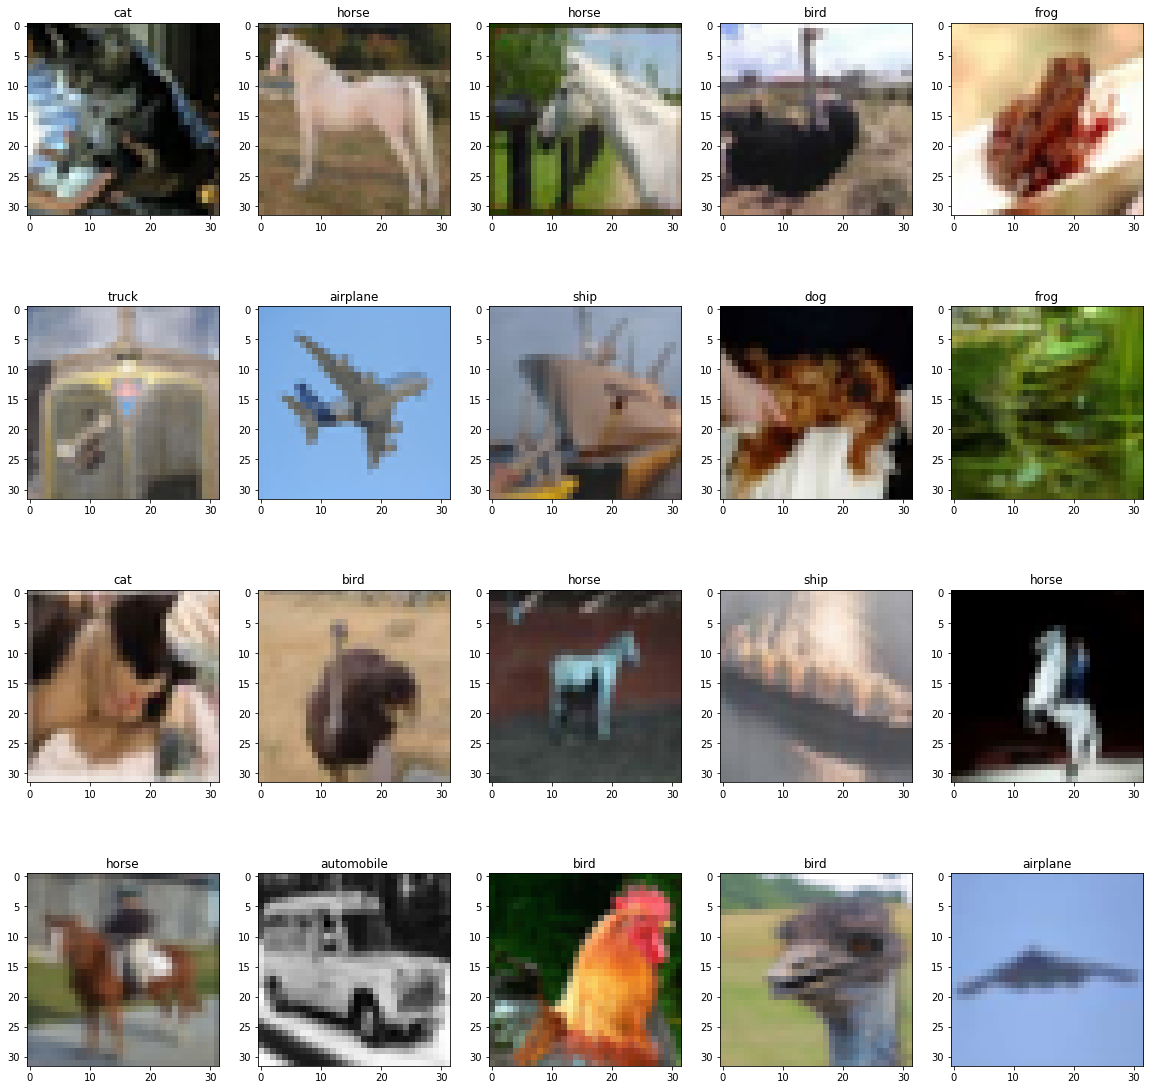

In [6]:
%matplotlib inline
fig = plt.figure(figsize=(20,20))
for indx in range(20):
    ax = fig.add_subplot(4,5,indx+1)
    plt.imshow(np.transpose((imgs[indx]/2)+0.5, (1, 2, 0)))
    ax.set_title(classes[labels[indx]])

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        #Layers
        #Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        
        #input (32*32*3) , out (32*32*32)
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        #input (32*32*32) , out (30*30*32)
        self.conv2 = nn.Conv2d(32,32,3)
        
        #input (15*15*32) , out (15*15*64)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        #input (15*15*64) , out (13*13*64)
        self.conv4 = nn.Conv2d(64,64,3)
        
        #Dense Layers 
        #Linear(in_features, out_features, bias=True)
        
        #input (6*6*64) , out (512)
        self.fc1 = nn.Linear(6*6*64,512)
        #input (512) , out (10)
        self.fc2 = nn.Linear(512,10)
        #maxpool
        #MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.maxpool = nn.MaxPool2d(2,2)
        
        #Dropout
        self.dropout = nn.Dropout(0.25)
        self.dropout_fc = nn.Dropout(0.5)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = x.view(-1,64*6*6)
        x = self.dropout_fc(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [16]:
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25)
  (dropout_fc): Dropout(p=0.5)
)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [23]:
epochs = 30
valid_loss_min = np.inf

for i in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions,labels)
        loss.backward()
        train_loss += loss.item() * images.size(0)
        optimizer.step()
    
    model.eval()
    for images, labels in validation_dataloader:
        images, labels = images.to(device), labels.to(device)
        predictions = model(images)
        loss = criterion(predictions,labels)
        valid_loss += loss.item() * images.size(0)
    
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(validation_dataloader.dataset)
    print('Epoch: {} \nTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        i, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 0 
Training Loss: 1.842694 	Validation Loss: 0.460621
Saving model ...
Epoch: 1 
Training Loss: 1.842715 	Validation Loss: 0.460754
Epoch: 2 
Training Loss: 1.842682 	Validation Loss: 0.460647
Epoch: 3 
Training Loss: 1.842532 	Validation Loss: 0.460676
Epoch: 4 
Training Loss: 1.842691 	Validation Loss: 0.460717
Epoch: 5 
Training Loss: 1.842741 	Validation Loss: 0.460647
Epoch: 6 
Training Loss: 1.842531 	Validation Loss: 0.460635
Epoch: 7 
Training Loss: 1.842638 	Validation Loss: 0.460718
Epoch: 8 
Training Loss: 1.842632 	Validation Loss: 0.460674
Epoch: 9 
Training Loss: 1.842613 	Validation Loss: 0.460727
Epoch: 10 
Training Loss: 1.842580 	Validation Loss: 0.460677
Epoch: 11 
Training Loss: 1.842690 	Validation Loss: 0.460754
Epoch: 12 
Training Loss: 1.842612 	Validation Loss: 0.460817
Epoch: 13 
Training Loss: 1.842555 	Validation Loss: 0.460785
Epoch: 14 
Training Loss: 1.842690 	Validation Loss: 0.460701
Epoch: 15 
Training Loss: 1.842592 	Validation Loss: 0.460902
E

In [ ]:
model.load_state_dict(torch.load('model_cifar.pt'))

In [28]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_dataloader:
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy()) #if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 2.303070

Test Accuracy of airplane:  0% ( 0/1000)
Test Accuracy of automobile:  0% ( 0/1000)
Test Accuracy of  bird: 100% (1000/1000)
Test Accuracy of   cat:  0% ( 0/1000)
Test Accuracy of  deer:  0% ( 0/1000)
Test Accuracy of   dog:  0% ( 0/1000)
Test Accuracy of  frog:  0% ( 0/1000)
Test Accuracy of horse:  0% ( 0/1000)
Test Accuracy of  ship:  0% ( 0/1000)
Test Accuracy of truck:  0% ( 0/1000)

Test Accuracy (Overall): 10% (1000/10000)
